In [98]:
include("../src/crustDistribution.jl")
include("../src/config.jl") # constants defined here 
include("../src/utilities.jl")

include("../src/invertData.jl")

using Plots; gr();

Loading crust information from file ../data/crustDistribution.jld


In [2]:
using StatGeochem

In [5]:
using MAT

In [7]:
# Read in mat file
ignp = matread("../igncn1.mat")
comp_compat, _ = convert_dabie("../data/kern_dabie_comp.csv")

([54.8 0.9 … 1.6 0.1; 49.9 1.3 … 1.8 0.1; … ; 48.1 1.3 … 1.7 0.3; 57.9 0.5 … 0.7 0.1], Any["D95-10", "D95-11", "D95-12", "D95-13", "D95-16", "D95-19", "D95-2", "D95-22", "D95-24", "D95-25"  …  "D95-6", "D95-7", "D95-9", "FH7", "HL3", "HL9", "HT1", "HT4", "HT6", "TC3"])

In [9]:
n = size(comp_compat)[1]
ign_new = Dict{String,Any}()
for re in RESAMPLED_ELEMENTS
    ign_new[re] = fill(NaN, n)
end
for (i, ce) in enumerate(COMPOSITION_ELEMENTS)
    ign_new[ce] = comp_compat[:,i]
end

ign_new["elements"] = RESAMPLED_ELEMENTS

# Set uncertainties
ign_new["err"] = Dict()
for e in RESAMPLED_ELEMENTS
    ign_new["err"][e] = ign_new[e] .* (ignp["err2srel"][e] / 2) # default
    ign_new["err"][e][isnan.(ign_new[e])] .= nanstd(ign_new[e]) # missing data gets std, which is a much larger uncertainty
end

# make this the usual ign 
ign = ign_new 

Dict{String,Any} with 54 entries:
  "Pd"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, Na…
  "MgO"   => [3.9, 7.7, 9.4, 0.5, 2.2, 6.8, 8.2, 1.0, 6.1, 8.5  …  6.6, 2.0, 0.…
  "Nb"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, Na…
  "Gd"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, Na…
  "Age"   => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, Na…
  "TiO2"  => [0.9, 1.3, 0.8, 0.2, 0.9, 0.9, 1.0, 0.5, 1.3, 0.8  …  1.9, 0.8, 0.…
  "Be"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, Na…
  "Sr"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, Na…
  "Ga"    => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, Na…
  "Al2O3" => [17.3, 15.6, 12.1, 13.8, 16.9, 14.8, 15.0, 13.9, 15.3, 19.3  …  17…
  "CO2"   => [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1  …  0.3, 0.1, 0.…
  "Y"     => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN

In [23]:
resampled = bsresample(ign, 100, RESAMPLED_ELEMENTS)

LoadError: [91mMethodError: no method matching getindex(::typeof(in), ::String)[39m

In [17]:
data = unelementify(ign, RESAMPLED_ELEMENTS, floatout=true)

30×52 Array{Float64,2}:
 54.8  0.9  17.3   7.71947    3.9   6.3  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 49.9  1.3  15.6   8.85954    7.7   8.3     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 53.9  0.8  12.1   6.42968    9.4   6.4     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 73.4  0.2  13.8   1.44991    0.5   1.2     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 60.7  0.9  16.9   5.55954    2.2   4.5     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 56.5  0.9  14.8   6.79962    6.8   5.6  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 48.3  1.0  15.0   9.18941    8.2  11.3     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 71.0  0.5  13.9   3.04972    1.0   3.2     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 52.4  1.3  15.3  11.7397     6.1   8.5     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 48.1  0.8  19.3   9.10983    8.5  10.8     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 56.0  1.2  16.2   8.5896     4.3   6.4  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 39.9  0.5   6.8  14.4692    30.3   3.6     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 49.3  0.4   3.7   8.90945   19.3  14.5 

In [65]:
 function dbsresample2(dataset, nrows, elements=dataset["elements"], p=min(0.2,nrows/length(elements[1]));
            kernel = gaussian,
            rng = MersenneTwister()
        )
        # 2d array of nominal values
        println("hello world")
        println(typeof(dataset))
        k = sort(collect(keys(dataset)))
        println(k)
        data = unelementify(dataset, elements, floatout=true)
        #return data

        # 2d array of absolute 1-sigma uncertainties
        if haskey(dataset, "err") && isa(dataset["err"], Dict)
            sigma = unelementify(dataset["err"], elements, floatout=true)
        else
            sigma = unelementify(dataset, elements.*"_sigma", floatout=true)
        end

        # Resample
        sdata = bsresample(data, sigma, nrows, p, kernel=kernel, rng=rng)
        return elementify(sdata, elements, skipstart=0)
    end

function difguy(dataset, nrows, elements)
    println("hello world")
    println(typeof(dataset))
    data = unelementify(dataset, elements, floatout=true)
end



difguy (generic function with 1 method)

In [66]:
resampled = dbsresample2(ign, 100, RESAMPLED_ELEMENTS)

LoadError: [91mUndefVarError: MersenneTwister not defined[39m

In [60]:
resampled

30×52 Array{Float64,2}:
 54.8  0.9  17.3   7.71947    3.9   6.3  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 49.9  1.3  15.6   8.85954    7.7   8.3     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 53.9  0.8  12.1   6.42968    9.4   6.4     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 73.4  0.2  13.8   1.44991    0.5   1.2     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 60.7  0.9  16.9   5.55954    2.2   4.5     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 56.5  0.9  14.8   6.79962    6.8   5.6  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 48.3  1.0  15.0   9.18941    8.2  11.3     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 71.0  0.5  13.9   3.04972    1.0   3.2     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 52.4  1.3  15.3  11.7397     6.1   8.5     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 48.1  0.8  19.3   9.10983    8.5  10.8     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 56.0  1.2  16.2   8.5896     4.3   6.4  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 39.9  0.5   6.8  14.4692    30.3   3.6     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 49.3  0.4   3.7   8.90945   19.3  14.5 

In [71]:
dat = getTestSeismic(10,8,0.0,["D95-44", "HT4", "D95-11"])

([2960.0, 2960.0, 2960.0, 2960.0, 2960.0, 2960.0, 2960.0, 2960.0, 2960.0, 2960.0], [8.743733713419577, 10.10955946709667, 9.478365529244297, 9.692234539674846, 9.793101983622446, 10.18573350649299, 8.989559798368878, 9.621700337000101, 8.8504088928829, 10.212927165228539], [2.1911765531060516, 2.3119623196319155, 2.224662795861963, 2.301115445543523, 2.5093135341993933, 2.301010422204367, 2.222995774085121, 2.3093486821728195, 2.2162451717603444, 2.2121848690067747], [35.02052755021214, 43.87677234872087, 44.38165938636652, 39.05395272344739, 28.764568163940407, 46.411002150705364, 36.013701569920975, 37.40244562213366, 34.45902742339055, 65.72063732432473])

In [72]:
dat[2]

10-element Array{Float64,1}:
  8.743733713419577
 10.10955946709667
  9.478365529244297
  9.692234539674846
  9.793101983622446
 10.18573350649299
  8.989559798368878
  9.621700337000101
  8.8504088928829
 10.212927165228539

In [73]:
dat[3]

10-element Array{Float64,1}:
 2.1911765531060516
 2.3119623196319155
 2.224662795861963
 2.301115445543523
 2.5093135341993933
 2.301010422204367
 2.222995774085121
 2.3093486821728195
 2.2162451717603444
 2.2121848690067747

In [80]:
dat2 = getAllSeismic(8,n=10,latlong=true,dataSrc="DabieRG",dataUncertainty=0.0);

Vs = 3.67 + 0.0001494 P + -0.001928 T 
Vp = 6.38 + 0.00044219999999999996 P + -0.002281 T 


In [78]:
dat2[1][2]

10-element Array{Float64,1}:
 9.261074999917824
 8.937955101842828
 9.434571288716048
 9.266989484857984
 9.235090747060658
 9.584562158087808
 8.925688398229456
 8.773940858170437
 9.336379204882734
 9.44266583371973

In [81]:
vs = 3.67+10e-4*1.494*909.4 - 10e-4*1.928*429
vp = 6.38+10e-4*4.422*909.4 - 10e-4*2.281*429

println("vp $vp vpvs $(vp/vs)")

vp 9.4228178 vpvs 2.2427102059639394


In [83]:
resdat, resh = readdlm("../data/remote/dabie/dabierf2/results-lower.csv", ',', header=true)
println("means $(nanmean(resdat[:,1])), $(nanmean(resdat[:,2])), $(nanmean(resdat[:,3]))")


means 2960.0, 9.435488209417962, 2.2509448489247985


In [84]:
P = 2.960 * 9.81 * 32 # P = rho*g*z 

929.2032

In [86]:
kdseis, kdh = readdlm("../data/kern_dabie_seismic.csv", ',', header=true);

In [88]:
kdh

1×8 Array{AbstractString,2}:
 ""  "rho (g/cm^3)"  "Vp0"  "Vs0"  "dVp=dP"  "dVs=dP"  "dVp=dT"  "dVs=dT"

In [112]:
## For avg geotherm (TC1=41 km), middle of avg lower crust (32 km), we have: 
P = 909 # MPa
T = 429 # degrees C 

vss = [] 
vps = [] 

for i in 1:size(kdseis)[1]
    append!(vss, kdseis[i,4] + 10^-4*kdseis[i,6]*P - 10^-4*kdseis[i,8]*T)
    append!(vps, kdseis[i,3] + 10^-4*kdseis[i,5]*P - 10^-4*kdseis[i,7]*T)
end

In [113]:
vpvss = vps ./ vss;

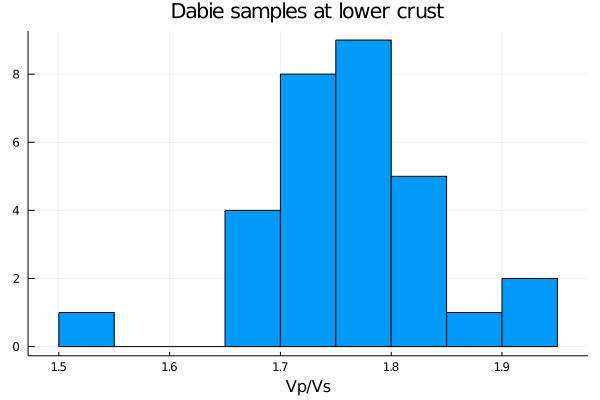

In [114]:
histogram(vpvss, label=false, xlabel="Vp/Vs", title="Dabie samples at lower crust")
#savefig("../../present/4_1/dabie_vpvs.pdf")

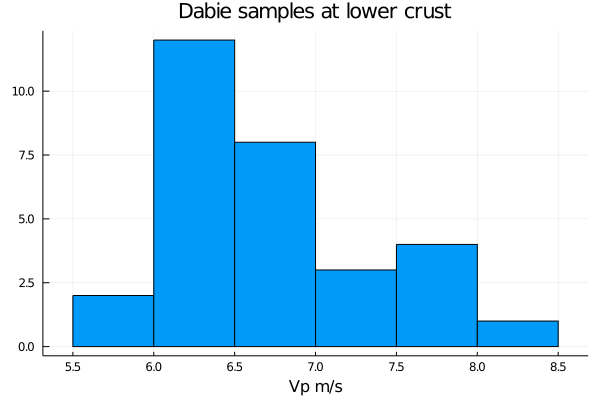

In [115]:
histogram(vps, label=false, xlabel="Vp m/s", title="Dabie samples at lower crust")
#savefig("../../present/4_1/dabie_vp.pdf")

In [108]:
kdseis

30×8 Array{Any,2}:
 "D95-10"  2.854  6.28  3.56  3.516  1.113  2.688  1.952
 "D95-11"  2.96   6.38  3.67  4.422  1.494  2.281  1.928
 "D95-12"  2.86   5.94  3.4   7.431  2.406  1.749  1.589
 "D95-13"  2.647  5.86  3.51  3.785  1.08   2.885  0.862
 "D95-16"  2.781  6.02  3.47  4.555  1.561  2.672  1.459
 "D95-19"  2.859  5.64  3.32  8.313  3.058  1.752  1.456
 "D95-2"   3.031  6.67  3.9   4.148  1.409  2.239  1.636
 "D95-22"  2.737  5.98  3.62  4.487  1.518  3.09   1.424
 "D95-24"  3.465  7.68  4.55  3.799  1.758  3.804  2.58
 "D95-25"  3.483  7.73  4.62  5.439  2.22   3.118  2.165
 "D95-26"  3.171  6.84  3.9   5.308  1.229  2.752  2.693
 "D95-27"  3.26   6.99  3.87  2.5    0.538  5.823  3.853
 "D95-3"   3.266  7.25  4.18  2.314  0.578  3.662  2.662
 ⋮                                   ⋮             
 "D95-40"  3.499  7.45  4.54  3.723  1.521  4.18   2.709
 "D95-44"  2.766  6.11  3.62  4.307  2.283  3.913  2.824
 "D95-6"   2.959  6.29  3.52  2.983  0.956  2.979  2.509
 "D95-7"   2.787  